<a href="https://colab.research.google.com/github/SidtheKidx/tone-classification-CadenceIQ/blob/main/tone_classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tone Classification-CadenceIQ using BERT Transformers


In [1]:
import pandas as pd 
import numpy as np

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [63]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
!pip install transformers
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
!pip install --upgrade pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from pylab import rcParams
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

     |████████████████████████████████| 808kB 28.2MB/s 
     |████████████████████████████████| 829kB 26.6MB/s 
     |████████████████████████████████| 112kB 36.3MB/s 
     |████████████████████████████████| 276kB 40.1MB/s 
     |████████████████████████████████| 645kB 34.5MB/s 
     |████████████████████████████████| 1.3MB 33.2MB/s 
     |████████████████████████████████| 296kB 47.2MB/s 
     |████████████████████████████████| 143kB 41.0MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=5bcc6d9d336c89d6e6a72c0a468b22b463c6173ec63a2100aa828bcf8601aaa2
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Global seed set to 42


42

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/SidtheKidx/tone-classification-CadenceIQ/main/datasets/Tones.csv?token=AJVH2HYYDHA7F3BZ44OVHFTAU7XYI')

In [3]:
df = df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], axis=1)

In [4]:
df.head(40)

,sentence,tones,tags
0,i didnt feel humiliated,"{ ""document_tone"": { ""tones"": [ { ...",['tentative']
1,i can go from feeling so hopeless to so damned...,"{ ""document_tone"": { ""tones"": [ { ...","['sadness', 'tentative']"
2,im grabbing a minute to post i feel greedy wrong,"{ ""document_tone"": { ""tones"": [ { ...",['sadness']
3,i am ever feeling nostalgic about the fireplac...,"{ ""document_tone"": { ""tones"": [ { ...","['sadness', 'analytical']"
4,i am feeling grouchy,"{ ""document_tone"": { ""tones"": [ { ...","['anger', 'sadness']"
5,ive been feeling a little burdened lately wasn...,"{ ""document_tone"": { ""tones"": [ { ...","['sadness', 'tentative']"
6,ive been taking or milligrams or times recomme...,"{ ""document_tone"": { ""tones"": [ { ...","['joy', 'tentative']"
7,i feel as confused about life as a teenager or...,"{ ""document_tone"": { ""tones"": [ { ...","['sadness', 'tentative']"
8,i have been with petronas for years i feel tha...,"{ ""document_tone"": { ""tones"": [ { ...",['joy']
9,i feel romantic too,"{ ""document_tone"": { ""tones"": [ { ...","['joy', 'tentative']"


In [5]:
#Forced to convert Tags column from LIST type to PANDAS DATAFRAME type
list_tones = []
c = 0

for json_data in df['tones']:
    fresh_list = [] 
    data_dict = json.loads(str(json_data))

    for document_tones in data_dict['document_tone']['tones']:
      fresh_list.append(document_tones['tone_id'])
      c+=1

    list_tones.append(fresh_list)

df['Tags'] = pd.Series(list_tones)

print(list_tones)
print(c)

[['tentative'], ['sadness', 'tentative'], ['sadness'], ['sadness', 'analytical'], ['anger', 'sadness'], ['sadness', 'tentative'], ['joy', 'tentative'], ['sadness', 'tentative'], ['joy'], ['joy', 'tentative'], ['sadness', 'analytical'], ['tentative'], ['joy', 'analytical'], ['tentative'], ['sadness', 'tentative'], ['fear'], ['analytical', 'tentative'], ['sadness', 'tentative'], ['joy'], ['tentative'], ['joy'], ['joy'], ['sadness'], ['anger'], ['tentative'], ['sadness', 'fear', 'tentative'], ['tentative'], ['sadness', 'tentative'], ['joy', 'confident'], ['analytical'], ['sadness'], ['anger', 'analytical'], ['sadness', 'analytical'], ['tentative', 'analytical'], ['sadness', 'analytical', 'tentative'], ['sadness', 'tentative', 'analytical'], ['sadness', 'tentative', 'analytical'], ['joy', 'tentative'], ['joy'], ['joy'], ['joy'], ['sadness'], ['tentative'], ['sadness'], ['sadness'], ['joy', 'confident'], ['sadness', 'analytical'], ['tentative'], ['tentative'], ['joy'], ['sadness', 'tentativ

In [6]:
df = df.drop(['tags'], axis=1)

In [7]:
df.head(10)

,sentence,tones,Tags
0,i didnt feel humiliated,"{ ""document_tone"": { ""tones"": [ { ...",[tentative]
1,i can go from feeling so hopeless to so damned...,"{ ""document_tone"": { ""tones"": [ { ...","[sadness, tentative]"
2,im grabbing a minute to post i feel greedy wrong,"{ ""document_tone"": { ""tones"": [ { ...",[sadness]
3,i am ever feeling nostalgic about the fireplac...,"{ ""document_tone"": { ""tones"": [ { ...","[sadness, analytical]"
4,i am feeling grouchy,"{ ""document_tone"": { ""tones"": [ { ...","[anger, sadness]"
5,ive been feeling a little burdened lately wasn...,"{ ""document_tone"": { ""tones"": [ { ...","[sadness, tentative]"
6,ive been taking or milligrams or times recomme...,"{ ""document_tone"": { ""tones"": [ { ...","[joy, tentative]"
7,i feel as confused about life as a teenager or...,"{ ""document_tone"": { ""tones"": [ { ...","[sadness, tentative]"
8,i have been with petronas for years i feel tha...,"{ ""document_tone"": { ""tones"": [ { ...",[joy]
9,i feel romantic too,"{ ""document_tone"": { ""tones"": [ { ...","[joy, tentative]"


## Encoding categorical data

In [8]:
y = pd.Series(df['Tags'])
x = pd.Series(df['sentence'])

In [9]:
# Encode the tags(labels) in a binary format in order to be used for training
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(y)
yt.shape

(6740, 7)

In [10]:
# Getting a sense of how the tags data looks like
print(yt[5])
print(mlb.inverse_transform(yt[5].reshape(1,-1)))
print(mlb.classes_)

[0 0 0 0 0 1 1]
[('sadness', 'tentative')]
['analytical' 'anger' 'confident' 'fear' 'joy' 'sadness' 'tentative']


In [11]:
#Visualising encoded categories
types_encoded = pd.DataFrame(mlb.fit_transform(df["Tags"]),columns=mlb.classes_)
types_encoded.head(-10)

,analytical,anger,confident,fear,joy,sadness,tentative
0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,1
2,0,0,0,0,0,1,0
3,1,0,0,0,0,1,0
4,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...
6725,0,0,1,0,1,0,0
6726,0,0,0,0,1,0,1
6727,1,0,0,0,0,0,0
6728,1,0,0,0,0,0,0


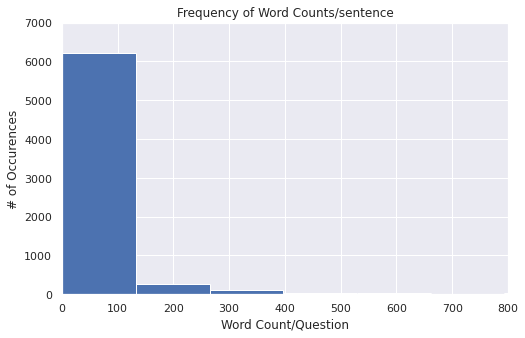

In [12]:
# compute no. of words in each question
questions = x
word_cnt = [len(quest.split()) for quest in questions]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlim([0, 800])
plt.ylim([0, 7000])
plt.xlabel('Word Count/Question')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

Max words = 200

## TF-IDF

In [14]:
'''
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df.sentence)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
'''

In [15]:
'''
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=9000)
X_tfidf_resampled, Y_tfidf_resampled = ros.fit_sample(X_tfidf, yt)
'''

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:
#x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf_resampled, Y_tfidf_resampled, test_size=0.2, random_state=9000)

Text(0.5, 1.0, 'class distribution in training set after resampling')

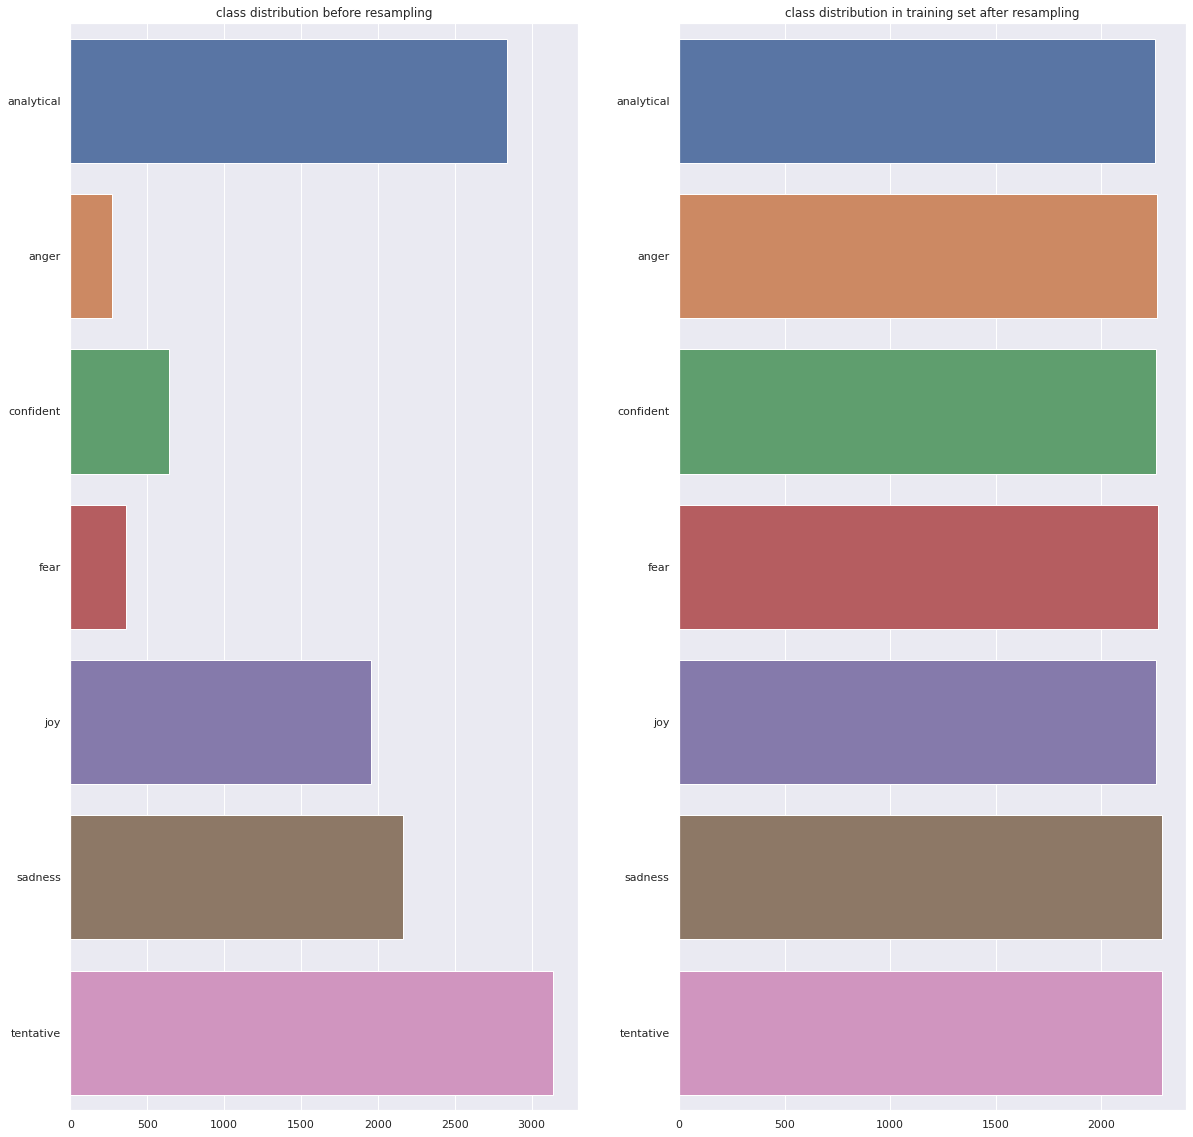

In [21]:
'''
fig = plt.figure(figsize=(20,20))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=yt.sum(axis=0), y=mlb.classes_, ax=ax_test)
g2 = sns.barplot(x=y_train_tfidf.sum(axis=0), y=mlb.classes_, ax=ax_train)
g1.set_title("class distribution before resampling")
g2.set_title("class distribution in training set after resampling")
'''

## Handling Imbalanced data
 

Text(0.5, 0, 'count of tags in the comments')

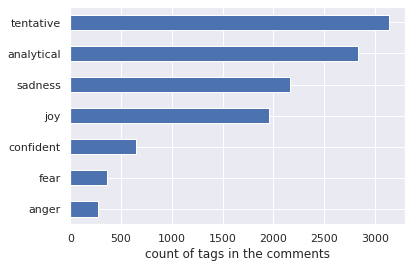

In [32]:
LABEL_COLUMNS = types_encoded.columns.tolist()[0:]
types_encoded[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")
plt.xlabel('count of tags in the comments')

In [33]:
types_encoded[LABEL_COLUMNS].sum().sort_values()

anger          274
fear           360
confident      643
joy           1953
sadness       2166
analytical    2837
tentative     3142
dtype: int64

In [44]:
df1 = df.copy()
df1 = pd.concat([df, types_encoded], axis=1)

In [46]:
df1 = df1.drop(['tones', 'Tags'], axis=1)

In [53]:
df1.head(10)

,sentence,analytical,anger,confident,fear,joy,sadness,tentative
0,i didnt feel humiliated,0,0,0,0,0,0,1
1,i can go from feeling so hopeless to so damned...,0,0,0,0,0,1,1
2,im grabbing a minute to post i feel greedy wrong,0,0,0,0,0,1,0
3,i am ever feeling nostalgic about the fireplac...,1,0,0,0,0,1,0
4,i am feeling grouchy,0,1,0,0,0,1,0
5,ive been feeling a little burdened lately wasn...,0,0,0,0,0,1,1
6,ive been taking or milligrams or times recomme...,0,0,0,0,1,0,1
7,i feel as confused about life as a teenager or...,0,0,0,0,0,1,1
8,i have been with petronas for years i feel tha...,0,0,0,0,1,0,0
9,i feel romantic too,0,0,0,0,1,0,1


In [57]:
#Split the data
train_df, val_df = train_test_split(df1, test_size=0.2)
train_df.shape, val_df.shape

((5392, 8), (1348, 8))

## Tokenization

In [58]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

NameError: ignored